In [1]:
import click as ck
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework import function
import re
import math
import matplotlib.pyplot as plt
import logging
from tensorflow.keras.layers import (
    Input,
)
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras import backend as K
from scipy.stats import rankdata

from elembeddings.elembedding import (
    ELModel, load_data, load_valid_data, Generator, MyModelCheckpoint)



### Set parameters

In [2]:
# Parameters
batch_size = 128
embedding_size = 50
margin = -0.1
reg_norm = 1
learning_rate = 1e-2
epochs = 10

### Load training and validation data

In [3]:
# Load training data in (h, l, t) triples
# classes and relations are entity to id mappings
train_data, classes, relations = load_data('data/data-train/yeast-classes-normalized.owl')
valid_data = load_valid_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
train_data.keys()

dict_keys(['nf1', 'nf2', 'nf3', 'nf4', 'disjoint', 'nf3_neg', 'top'])

In [4]:
# Filter out protein classes
proteins = {}
for k, v in classes.items():
    if not k.startswith('<http://purl.obolibrary.org/obo/GO_'):
        proteins[k] = v

# Prepare data for training the model
nb_classes = len(classes)
nb_relations = len(relations)
nb_train_data = 0
for key, val in train_data.items():
    nb_train_data = max(len(val), nb_train_data)
train_steps = int(math.ceil(nb_train_data / (1.0 * batch_size)))
train_generator = Generator(train_data, batch_size, steps=train_steps)

# id to entity maps
cls_dict = {v: k for k, v in classes.items()}
rel_dict = {v: k for k, v in relations.items()}

cls_list = []
rel_list = []
for i in range(nb_classes):
    cls_list.append(cls_dict[i])
for i in range(nb_relations):
    rel_list.append(rel_dict[i])

        
print('Total number of classes', nb_classes)
print('Total number of relations', nb_relations)

Total number of classes 10505
Total number of relations 6


### Build ELEmbeddings Model and Train

Embeddings are saved depending on mean rank evaluation on validation set

In [5]:
# Input layers for each loss type
nf1 = Input(shape=(2,), dtype=np.int32)
nf2 = Input(shape=(3,), dtype=np.int32)
nf3 = Input(shape=(3,), dtype=np.int32)
nf4 = Input(shape=(3,), dtype=np.int32)
dis = Input(shape=(3,), dtype=np.int32)
top = Input(shape=(1,), dtype=np.int32)
nf3_neg = Input(shape=(3,), dtype=np.int32)

# Build model
el_model = ELModel(nb_classes, nb_relations, embedding_size, batch_size, margin, reg_norm)
out = el_model([nf1, nf2, nf3, nf4, dis, top, nf3_neg])
model = tf.keras.Model(inputs=[nf1, nf2, nf3, nf4, dis, top, nf3_neg], outputs=out)
optimizer = optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# Pandas files to store embeddings
out_classes_file = 'data/cls_embeddings.pkl'
out_relations_file = 'data/rel_embeddings.pkl'

# ModelCheckpoint which runs at the end of each epoch
checkpointer = MyModelCheckpoint(
    out_classes_file=out_classes_file,
    out_relations_file=out_relations_file,
    cls_list=cls_list,
    rel_list=rel_list,
    valid_data=valid_data,
    proteins=proteins,
    monitor='loss')

# Start training
model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    workers=12,
    callbacks=[checkpointer,])


/home/borg/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
2677/2684 [============================>.] - ETA: 0s - loss: 2.7510
 Saving embeddings 1 1723.7598727002417

2684/2684 [==============================] - 43s 16ms/step - loss: 2.7441
Epoch 2/10
2678/2684 [============================>.] - ETA: 0s - loss: 0.2082
 Saving embeddings 2 1134.7343895186768

2684/2684 [==============================] - 41s 15ms/step - loss: 0.2082
Epoch 3/10
2683/2684 [============================>.] - ETA: 0s - loss: 0.2213
 Saving embeddings 3 1037.4568388775322

2684/2684 [==============================] - 41s 15ms/step - loss: 0.2213
Epoch 4/10
2684/2684 [==============================] - 42s 16ms/step - loss: 0.2170
Epoch 5/10
2684/2684 [==============================] - 42s 16ms/step - loss: 0.2107
Epoch 6/10
2680/2684 [============================>.] - ETA: 0s - loss: 0.2083
 Saving embeddings 6 1035.9826705073406

2684/2684 [==============================] - 43s 16ms/step - loss: 0.2082
Epoch 7/10
2684/2684 [==============================] 

### Evaluation of embeddings on the test set

In [8]:
def load_test_data(data_file, classes, relations):
    data = []
    rel = f'<http://interacts>'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'<http://{it[0]}>'
            id2 = f'<http://{it[1]}>'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

cls_df = pd.read_pickle(out_classes_file)
rel_df = pd.read_pickle(out_relations_file)
nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

rs = np.abs(embeds[:, -1]).reshape(-1, 1)
embeds = embeds[:, :-1]
prot_index = list(proteins.values())
prot_rs = rs[prot_index, :]
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

train_data = load_test_data('data/data-train/4932.protein.links.v10.5.txt', classes, relations)
valid_data = load_test_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000

test_data = load_test_data('data/data-test/4932.protein.links.v10.5.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    rc = prot_rs[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute similarity
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    dst = dst.reshape(-1, 1)
    res = np.maximum(0, dst - rc - prot_rs - margin)
    res = res.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

0.05 0.32 1028.66 0.81
0.12 0.40 979.73 0.82


### TSNE plot


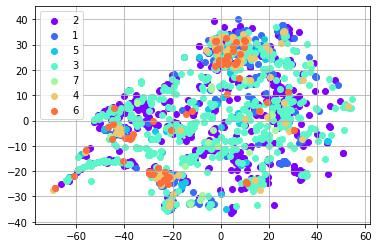

In [10]:
from matplotlib.pyplot import cm
from matplotlib import pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(prot_embeds)

# Load EC numbers
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '<http://{0}>'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

ec_classes = {'0': [[], []]}
for i, item in enumerate(proteins.items()):
    k, v = item
    if k in ec_numbers:
        ec = ec_numbers[k].split('.')[0]
        if ec not in ec_classes:
            ec_classes[ec] = [[], []]
        ec_classes[ec][0].append(X[i, 0])
        ec_classes[ec][1].append(X[i, 1])
    else:
        ec_classes['0'][0].append(X[i, 0])
        ec_classes['0'][1].append(X[i, 1])
    
colors = iter(cm.rainbow(np.linspace(0, 1, len(ec_classes))))
fig, ax = plt.subplots()

for ec, items in ec_classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()


### Task 1: Infer superclasses of a query class

In [19]:
query = '<http://purl.obolibrary.org/obo/GO_0030953>'